In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [43]:
n_rows = 7
n_cols = 10
gridworld = np.zeros((n_rows, n_cols))

In [77]:
init_pos = np.array([3, 0])
goal_pos = np.array([3, 7])

In [147]:
strength = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

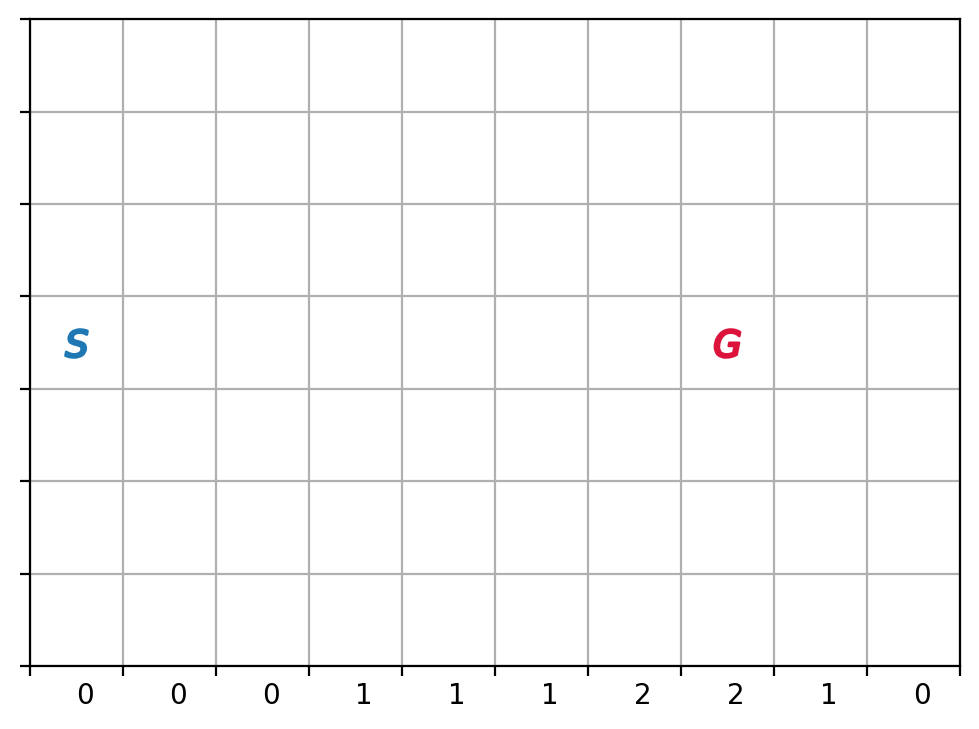

In [157]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)

init = init_pos[::-1] + 0.5
goal = goal_pos[::-1] + 0.5
ax.scatter(*init, marker="$S$", s=100)
ax.scatter(*goal, marker="$G$", s =100, c="crimson")
# plt.scatter(*finish_pos)

ax.set_xticks(xticks, labels="")
plt.yticks(yticks, labels="")

# TODO: change for minor xticks
for x, s in enumerate(strength):
    plt.text(x + 0.5, -0.4, s)

plt.grid()

In [187]:
actions = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # up,
    [-1, 0], # down
])
n_actions = len(actions)

In [205]:
Q = np.zeros((n_rows, n_cols, n_actions)) # action-value function

In [206]:
epsilon = 0.1
pos = init_pos.copy()

In [207]:
Q.shape

(7, 10, 4)

In [ ]:
def choose_action(qval):
    action_greedy = qval.max()
    

In [208]:
pos

array([3, 0])

In [209]:
Q[*pos]

array([0., 0., 0., 0.])